In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler #学习率衰减
from torchvision import models, transforms
from efficientnet_pytorch import EfficientNet

from sklearn import model_selection, metrics

In [2]:
DATA_PATH = './demo/'
img0_path = './demo/with_mask/'
img1_path = './demo/incorrect_mask/'
img2_path = './demo/without_mask/'
Continue = 1 #调用上一次训练的模型

class_num=3
IMG_SIZE=224
batch_size=64
epochs = 10  # 训练数据集的轮次
lr_rate=1e-4
gamma=0.98
weight_decay = 0.0
lr_patience = 1 # 1 model not improving until lr is decreasing
lr_factor = 0.5 # by how much the lr is decreasing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 用GPU还是CPU
print(device)

cuda


In [3]:
train_df=pd.DataFrame(columns=['img_path','img_label'])
for i in range(3):
    image_path=eval('img{}_path'.format(i))
    for img_name in os.listdir(image_path):
        img_path=os.path.join(image_path, img_name)
        img_label=i
        train_df=train_df.append(pd.DataFrame({'img_path':[img_path],'img_label':[img_label]}))
train_df=train_df.reset_index(drop=True)
train_df.to_csv(DATA_PATH+'/train.csv',index=False)
train_df.head()

,img_path,img_label
0,./demo/with_mask/0-with-mask.jpg,0
1,./demo/with_mask/0003.jpg,0
2,./demo/with_mask/0006.jpg,0
3,./demo/with_mask/0018.jpg,0
4,./demo/with_mask/0019.jpg,0


In [4]:
# import seaborn as sns
# sns.countplot(data=train_df, x='img_label')

In [5]:
train_df, valid_df = model_selection.train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df.img_label.values)
train_df.head()

,img_path,img_label
1023,./demo/with_mask/augmented_image_20.jpg,0
1254,./demo/incorrect_mask/aug_161.jpg,1
2566,./demo/without_mask/augmented_image_84.jpg,2
2183,./demo/without_mask/404.jpg,2
695,./demo/with_mask/308-with-mask.jpg,0


In [6]:
class FaceDataset(Dataset):
    def __init__(self, df, data_path=DATA_PATH,transforms=None):
        super(FaceDataset,self).__init__()
        self.df_data = df
        self.data_path = data_path
        self.transforms = transforms
    
    def __len__(self):
        return len(self.df_data)
    
    def __getitem__(self,index):
        img_path,label = self.df_data.iloc[index]
        label=torch.tensor(np.array(label), dtype=torch.float32).long()
        #img = Image.open(img_path).convert("RGB")
        img = cv2.imread(img_path)  
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0,0) ,256/10), -4, 128)
        
        if self.transforms is not None:
            image = self.transforms(img)
        
        return image,label

In [7]:
# create image augmentations
transforms_train = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((256, 256),interpolation = cv2.INTER_AREA),
        transforms.RandomHorizontalFlip(p=0.3), #随机水平旋转
        transforms.RandomVerticalFlip(p=0.3), #随机垂直旋转
        transforms.RandomRotation(45), #随机旋转
        transforms.ColorJitter(brightness=[0.7, 1.3], contrast=[0.7, 1.3], saturation=[0.7, 1.3], hue=[-0.1, 0.1]), #修改亮度、对比度和饱和度
        transforms.RandomResizedCrop((IMG_SIZE, IMG_SIZE), scale=(0.8, 1.0)), #随机裁剪
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

transforms_valid = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((IMG_SIZE, IMG_SIZE),interpolation = cv2.INTER_AREA),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

image shape: torch.Size([64, 3, 224, 224])
label shape: torch.Size([64])


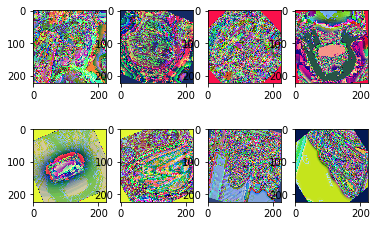

In [8]:
train_dataset = FaceDataset(train_df,transforms=transforms_train)
valid_dataset = FaceDataset(valid_df,transforms=transforms_valid)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

for images, labels in train_loader:
    image_example = images
    label_example = torch.tensor(np.array(labels),dtype=torch.float32)
    break

print('image shape:',image_example.size())
print('label shape:',label_example.size())

show=transforms.ToPILImage() # 可以把Tensor转成Image，方便可视化
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(show(image_example[i]))
plt.show()

In [9]:
# 用于ResNet18和34的残差块，用的是2个3x3的卷积
class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock,self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        self.relu = nn.ReLU(inplace=True)
        # 经过处理后的x要与x的维度相同(尺寸和深度)
        # 如果不相同，需要添加卷积+BN来变换为同一维度
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
        pass
    
    def forward(self,x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out
    
# 用于ResNet50,101和152的残差块，用的是1x1+3x3+1x1的卷积
class Bottleneck(nn.Module):
    expansion = 4
    
    def __init__(self,in_planes,planes,stride=1):
        super(Bottleneck,self).__init__()
        self.conv1 = nn.Conv2d(in_planes ,planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        
        self.conv2 = nn.Conv2d(planes ,planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.conv3 = nn.Conv2d(planes ,planes*self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes*self.expansion)
        
        self.relu = nn.ReLU(inplace=True)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
        pass
    
    def forward(self,x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=3):
        super(ResNet,self).__init__()
        self.in_planes = 64
        # 网络输入部分
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # 中间卷积部分
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # 平均池化和全连接层
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.linear = nn.Linear(512*block.expansion, num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        pass
    
    def _make_layer(self,block,planes,num_blocks,stride):
        strides=[stride]+[1]*(num_blocks-1) #一个box_block中的图片大小只在第一次除以2
        layers=[]
        for s in strides:
            layers.append(block(self.in_planes,planes,s))
            self.in_planes = block.expansion * planes
        return nn.Sequential(*layers)
    
    def forward(self,x):
        out = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0),-1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])

In [9]:
def train(device, train_loader):
    # 模型训练
    model.train()
    
    train_loss =0.0
    correct = 0
    total = 0
    for batch_idx,(inputs,target) in enumerate(train_loader):
        # 部署到device
        inputs,target = inputs.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs,target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        _,predicted = torch.max(outputs.data,dim=1)
        total += target.size(0)
        correct += (predicted==target).sum().item()
        
        if batch_idx%20==19:
            print('[%d,%5d] loss:%.3f' % (epoch+1,batch_idx+1,train_loss/(batch_idx+1)))
    
    correct = correct/total
    train_loss = train_loss/(batch_idx+1)
    return train_loss,round(correct,2)

def valid(device,valid_loader):
    # 模型验证
    model.eval()
    
    valid_loss =0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx,(images, labels) in enumerate(valid_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs,labels)
            valid_loss += loss.item()
            
            r,predicted = torch.max(outputs.data,dim=1)
            total += labels.size(0)
            correct += (predicted==labels).sum().item()
    
    correct = correct/total
    valid_loss = valid_loss/(batch_idx+1)
    print('Accuracy on test set: %d %%' % (100*correct))
    return valid_loss,round(correct,2)

def retrain(DATA_PATH,model_name):
    model_path = os.path.join(DATA_PATH, 'best_{}_model.pth.tar'.format(model_name))
    assert os.path.isfile(model_path)
    checkpoint = torch.load(model_path)
    best_acc = checkpoint['best_acc']
    start_epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    print('Load bet_model at epoch {:.3f}.'.format(start_epoch))
    print('Best lr_rate is :{:.6f}'.format(optimizer.param_groups[0]['lr']))
    print('Best accuracy so far {:.3f}.'.format(best_acc))
    return best_acc

0.0009223681599999999
Load bet_model at epoch 4.000.
Best accuracy so far 0.953.
[1,   10] loss:0.194
[1,   20] loss:0.217
Accuracy on test set: 93 %
[2,   10] loss:0.243
[2,   20] loss:0.241
Accuracy on test set: 86 %
[3,   10] loss:0.185
[3,   20] loss:0.207
Accuracy on test set: 92 %
[4,   10] loss:0.164
[4,   20] loss:0.185
Accuracy on test set: 95 %
[5,   10] loss:0.207
[5,   20] loss:0.190
Accuracy on test set: 95 %
[6,   10] loss:0.115
[6,   20] loss:0.122
Accuracy on test set: 95 %
[7,   10] loss:0.121
[7,   20] loss:0.133
Accuracy on test set: 95 %


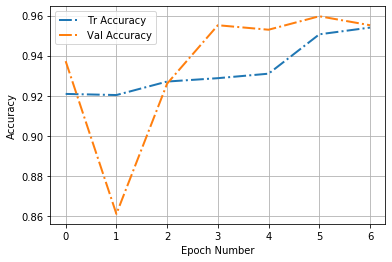

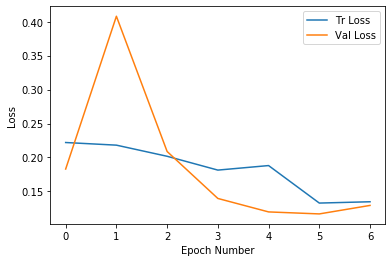

In [22]:
if __name__== '__main__':
    #调用模型
    model = ResNet34().to(device)
    #optimizer = torch.optim.SGD(model.parameters(),lr=0.01,momentum = 0.9, weight_decay=1e-3)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4)
    if Continue:
        best_acc=retrain(DATA_PATH)
    else:
        best_acc=0
    #loss
    criterion = torch.nn.CrossEntropyLoss()
    #学习率指数衰减
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    #scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='max', patience=lr_patience, verbose=True, factor=lr_factor)
    
    #训练
    history=[]
    best_correct=best_acc if best_acc else 0
    for epoch in range(epochs):
        train_loss,train_correct=train(device,train_loader)
        valid_loss,valid_correct=valid(device,valid_loader)
        scheduler.step()
        history.append([train_loss,valid_loss,train_correct,valid_correct])
        
        # save best_acc
        if valid_correct>best_correct:
            best_correct = valid_correct
            bestpoint = {
                'best_acc': best_correct,
                'epoch': epoch + 1,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }
            best_model_path = os.path.join(DATA_PATH, 'best_model.pth.tar')
            torch.save(bestpoint,best_model_path) #save best model
            
    history=np.array(history)
    #保存网络参数
    plt.plot(history[:,2:4], ls="-.", lw=2)
    plt.legend(['Tr Accuracy', 'Val Accuracy'])
    plt.xlabel('Epoch Number')
    plt.ylabel('Accuracy')
    plt.grid()#网格
    plt.show()
    #梯度下降曲线
    plt.plot(history[:,0:2])
    plt.legend(['Tr Loss', 'Val Loss'])
    plt.xlabel('Epoch Number')
    plt.ylabel('Loss')
    plt.show()

In [10]:
def choose_model(model_name,class_num):
    if 'vgg' in model_name:
        #加载预训练网络
        if model_name == 'vgg11':
            vgg = models.vgg11(pretrained=False)
            vgg.load_state_dict(torch.load('./vgg11-bbd30ac9.pth'))
        else:
            vgg = models.vgg16(pretrained=True)
        #微调最后一个全连接层，其它层的梯度不更新,vgg一共有13层
        count=0
        for child in vgg.children():
            count+=1
            if count <= 2:
                for param in child.parameters():
                    param.requires_grad = False
        #修改全连接层
        fc_input = vgg.classifier[6].in_features
        vgg.classifier[6] = nn.Linear(fc_input,class_num)
        return vgg

    elif 'resnet' in model_name:
        #加载预训练网络
        if model_name == 'resnet34':
            resnet = models.resnet34(pretrained=True)
        else:
            resnet = models.resnet50(pretrained=False)
            resnet.load_state_dict(torch.load('./resnet50-19c8e357.pth'))
        
        #微调最后一个卷积层和全连接层，其它层的梯度不更新,resnet一共有10层
        count=0
        for child in resnet.children():
            count+=1
            if count <= 7:
                for param in child.parameters():
                    param.requires_grad = False

        #修改全连接层
        fc_input = resnet.fc.in_features
        resnet.fc = nn.Sequential(
            nn.Linear(fc_input,256),
            nn.ReLU(True),
            nn.Dropout(0.4),
            nn.Linear(256,class_num)
        )
        return resnet

    elif 'EfficientNet'.lower() in model_name:
        #加载预训练网络,vgg一共有9层
        efficientnet = EfficientNet.from_name(model_name)
        efficientnet.load_state_dict(torch.load('./efficientnet-b4-6ed6700e.pth'))
        
        #修改全连接层
        fc_input = efficientnet._fc.in_features
        efficientnet._fc = nn.Sequential(
            nn.Linear(fc_input,256),
            nn.ReLU(True),
            nn.Dropout(0.4),
            nn.Linear(256,class_num)
        )
        return efficientnet
    
    else:
        print('There is no call to this model outside.')
    return 0

begin to train!
[1,   20] loss:1.006
Accuracy on test set: 86 %
[2,   20] loss:0.450
Accuracy on test set: 90 %
[3,   20] loss:0.224
Accuracy on test set: 93 %
[4,   20] loss:0.121
Accuracy on test set: 94 %
[5,   20] loss:0.109
Accuracy on test set: 96 %
[6,   20] loss:0.078
Accuracy on test set: 95 %
[7,   20] loss:0.071
Accuracy on test set: 95 %
Epoch     6: reducing learning rate of group 0 to 4.0000e-05.
[8,   20] loss:0.041
Accuracy on test set: 97 %
[9,   20] loss:0.048
Accuracy on test set: 97 %
[10,   20] loss:0.029
Accuracy on test set: 97 %
Epoch     9: reducing learning rate of group 0 to 1.6000e-05.


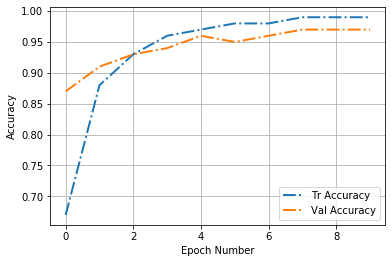

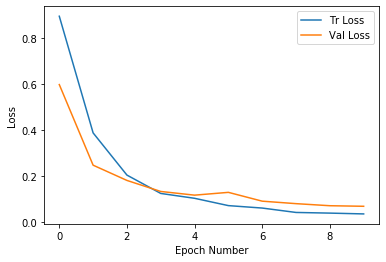

In [11]:
#模型加载
model_name='efficientnet-b4'
model = choose_model(model_name,class_num).to(device)

if 'vgg' in model_name:
    optimizer = torch.optim.Adam(model.classifier.parameters(),lr=lr_rate,betas=(0.9, 0.999),weight_decay=1e-3)

elif 'resnet' in model_name:
    #设置layer4和fc层的学习率，过滤其它层的参数
    #layer4_params = list(map(id, model.layer4.parameters()))
    #conv_params = (p for p in model.parameters() if id(p) not in fc_params)
    #bas_params = filter(lambda p:p.requires_grad and id(p) not in layer4_params, model.parameters())
    parameters = [{'params':model.layer4.parameters()},
                 {'params':model.fc.parameters(),'lr':lr_rate/10}]
    optimizer = torch.optim.Adam(parameters,lr=lr_rate,betas=(0.9, 0.999),weight_decay=1e-3)

else:
    optimizer = torch.optim.Adam(model.parameters(),lr=lr_rate,betas=(0.9, 0.999),weight_decay=1e-3)

#学习率指数衰减
#scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='max', 
                                patience=lr_patience, verbose=True, factor=lr_factor)
#loss
criterion = torch.nn.CrossEntropyLoss()

# for name,_ in resnet50.named_parameters():
#     print(name)

if __name__== '__main__':
    if 0:
        best_acc=retrain(DATA_PATH,model_name)
    else:
        best_acc=0
    
    #训练
    print('begin to train!')
    history=[]
    best_correct=best_acc if best_acc else 0
    for epoch in range(epochs):
        train_loss,train_correct=train(device,train_loader)
        valid_loss,valid_correct=valid(device,valid_loader)
        scheduler.step(valid_correct)
        history.append([train_loss,valid_loss,train_correct,valid_correct])
        
        # save best_acc
        if valid_correct>best_correct:
            best_correct = valid_correct
            bestpoint = {
                'best_acc': best_correct,
                'epoch': epoch + 1,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }
            best_model_path = os.path.join(DATA_PATH, 'best_{}_model.pth.tar'.format(model_name))
            torch.save(bestpoint,best_model_path) #save best model
    torch.cuda.empty_cache() #清除gpu缓存
            
    history=np.array(history)
    #保存网络参数
    plt.plot(history[:,2:4], ls="-.", lw=2)
    plt.legend(['Tr Accuracy', 'Val Accuracy'])
    plt.xlabel('Epoch Number')
    plt.ylabel('Accuracy')
    plt.grid()#网格
    plt.show()
    #梯度下降曲线
    plt.plot(history[:,0:2])
    plt.legend(['Tr Loss', 'Val Loss'])
    plt.xlabel('Epoch Number')
    plt.ylabel('Loss')
    plt.show()

In [30]:
torch.cuda.is_available()

'1.5.1+cpu'